# BMW Price Prediction (Regression)

In [265]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from fast_ml.feature_selection import get_constant_features
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
import lightgbm
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import pickle

warnings.simplefilter('ignore')
%matplotlib inline

In [177]:
df = pd.read_csv('bmw_pricing_challenge.csv')
df

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,BMW,218 Gran Tourer,39743,110,2015-10-01,diesel,black,van,False,True,False,False,False,False,True,False,14600,2018-08-01
4839,BMW,218 Active Tourer,49832,100,2015-06-01,diesel,grey,van,False,True,False,False,False,False,True,True,17500,2018-08-01
4840,BMW,218 Gran Tourer,19633,110,2015-10-01,diesel,grey,van,False,True,False,False,False,False,True,True,17000,2018-09-01
4841,BMW,218 Active Tourer,27920,110,2016-04-01,diesel,brown,van,True,True,False,False,False,False,True,True,22700,2018-09-01


In [267]:
# ProfileReport(df)

1. maker_key is constant - drop it
2. model_key can be checked with feature selection
3. Handling categorical columns
4. handling true,false in all features (1-8)
5. registration and sold date will give us the insight of how old the car (age of the car)
6. mileage has negative number - not possible - drop the row
7. engine power has minimum value as 0 - not possible - drop the row

# Checking for constant and quasi-constant features

In [114]:
get_constant_features(df) #result matching with our inference from profile report

,Desc,Var,Value,Perc
0,Constant,maker_key,BMW,100.0


In [178]:
#dropping maker_key

df.drop(columns=['maker_key'], inplace = True)

In [116]:
df.columns

Index(['model_key', 'mileage', 'engine_power', 'registration_date', 'fuel',
       'paint_color', 'car_type', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'price', 'sold_at'],
      dtype='object')

# Checking for duplicate rows and columns

In [117]:
#checking row-wise
df.duplicated().sum()

0

In [118]:
#checking column-wise
df.T.duplicated().sum()

0

In [92]:
df

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,218 Gran Tourer,39743,110,2015-10-01,diesel,black,van,False,True,False,False,False,False,True,False,14600,2018-08-01
4839,218 Active Tourer,49832,100,2015-06-01,diesel,grey,van,False,True,False,False,False,False,True,True,17500,2018-08-01
4840,218 Gran Tourer,19633,110,2015-10-01,diesel,grey,van,False,True,False,False,False,False,True,True,17000,2018-09-01
4841,218 Active Tourer,27920,110,2016-04-01,diesel,brown,van,True,True,False,False,False,False,True,True,22700,2018-09-01


# Categorical Encoding

In [93]:
le = LabelEncoder()

In [94]:
df.dtypes

model_key            object
mileage               int64
engine_power          int64
registration_date    object
fuel                 object
paint_color          object
car_type             object
feature_1              bool
feature_2              bool
feature_3              bool
feature_4              bool
feature_5              bool
feature_6              bool
feature_7              bool
feature_8              bool
price                 int64
sold_at              object
dtype: object

#### Replacing the values in columns can also work

In [179]:
df['model_key'] = le.fit_transform(df['model_key'])+1

In [180]:
#+1 to avoid 0
df['fuel'] = le.fit_transform(df['fuel'])+1
df['paint_color'] = le.fit_transform(df['paint_color'])+1
df['car_type'] = le.fit_transform(df['car_type'])+1

In [121]:
df.dtypes

model_key             int32
mileage               int64
engine_power          int64
registration_date    object
fuel                  int32
paint_color           int32
car_type              int32
feature_1              bool
feature_2              bool
feature_3              bool
feature_4              bool
feature_5              bool
feature_6              bool
feature_7              bool
feature_8              bool
price                 int64
sold_at              object
dtype: object

# Encoding the date 

In [122]:
df['registration_date'].sort_values()

2771    1990-03-01
3062    1994-01-01
25      1995-10-01
41      1996-08-01
2829    1996-10-01
           ...    
3588    2017-02-01
2938    2017-03-01
3902    2017-04-01
3935    2017-07-01
140     2017-11-01
Name: registration_date, Length: 4843, dtype: object

In [181]:
#manually binning the dates to 3 bins with 1,2,3 as their values with a gap of 10 years
df['registration_date'] = [1 if(i>="1990-03-01" and i<"2000-01-01") else 2 if(i>="2000-01-01" and i<"2010-01-01")
                            else 3 for i in df['registration_date']]

In [124]:
df['sold_at'].sort_values() #only 1 year

0       2018-01-01
314     2018-01-01
313     2018-01-01
312     2018-01-01
311     2018-01-01
           ...    
2455    2018-09-01
2454    2018-09-01
2453    2018-09-01
2034    2018-09-01
4842    2018-09-01
Name: sold_at, Length: 4843, dtype: object

In [125]:
df['sold_at'].unique()

array(['2018-01-01', '2018-02-01', '2018-04-01', '2018-03-01',
       '2018-09-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01'], dtype=object)

##### Rather than creating bins for "sold_at", it is better to replace these values manually.

In [182]:
df['sold_at'] = df['sold_at'].replace('2018-01-01',1)
df['sold_at'] = df['sold_at'].replace('2018-02-01',2)
df['sold_at'] = df['sold_at'].replace('2018-04-01',3)
df['sold_at'] = df['sold_at'].replace('2018-03-01',4)
df['sold_at'] = df['sold_at'].replace('2018-09-01',5)
df['sold_at'] = df['sold_at'].replace('2018-05-01',6)
df['sold_at'] = df['sold_at'].replace('2018-06-01',7)
df['sold_at'] = df['sold_at'].replace('2018-07-01',8)
df['sold_at'] = df['sold_at'].replace('2018-08-01',9)

In [127]:
df

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,3,140411,100,3,1,2,1,True,True,False,False,True,True,True,False,11300,1
1,62,13929,317,3,4,6,1,True,True,False,False,False,True,True,True,69700,2
2,22,183297,120,3,1,10,1,False,False,False,False,True,False,True,False,10200,2
3,32,128035,135,3,1,8,1,True,True,False,False,True,True,True,True,25100,2
4,34,97097,160,3,1,9,1,True,True,False,False,False,True,True,True,33400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,14,39743,110,3,1,2,8,False,True,False,False,False,False,True,False,14600,9
4839,13,49832,100,3,1,6,8,False,True,False,False,False,False,True,True,17500,9
4840,14,19633,110,3,1,6,8,False,True,False,False,False,False,True,True,17000,5
4841,13,27920,110,3,1,4,8,True,True,False,False,False,False,True,True,22700,5


## Encoding true,false of all features

In [183]:
for i in range(1,9):
    df['feature_'+str(i)]=df['feature_'+str(i)].replace('True',1).replace('False',0)
    df['feature_'+str(i)]=df['feature_'+str(i)].astype(int)

In [184]:
df

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,3,140411,100,3,1,2,1,1,1,0,0,1,1,1,0,11300,1
1,62,13929,317,3,4,6,1,1,1,0,0,0,1,1,1,69700,2
2,22,183297,120,3,1,10,1,0,0,0,0,1,0,1,0,10200,2
3,32,128035,135,3,1,8,1,1,1,0,0,1,1,1,1,25100,2
4,34,97097,160,3,1,9,1,1,1,0,0,0,1,1,1,33400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,14,39743,110,3,1,2,8,0,1,0,0,0,0,1,0,14600,9
4839,13,49832,100,3,1,6,8,0,1,0,0,0,0,1,1,17500,9
4840,14,19633,110,3,1,6,8,0,1,0,0,0,0,1,1,17000,5
4841,13,27920,110,3,1,4,8,1,1,0,0,0,0,1,1,22700,5


In [130]:
df.dtypes

model_key            int32
mileage              int64
engine_power         int64
registration_date    int64
fuel                 int32
paint_color          int32
car_type             int32
feature_1            int32
feature_2            int32
feature_3            int32
feature_4            int32
feature_5            int32
feature_6            int32
feature_7            int32
feature_8            int32
price                int64
sold_at              int64
dtype: object

# Mileage and engine power

In [185]:
columns = df[(df['mileage']<=0) | (df['engine_power']<=0)] # 2 rows
columns

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
2938,52,-64,230,3,1,2,5,1,1,0,1,0,0,1,1,75000,3
3765,65,81770,0,3,1,10,7,0,0,0,0,0,0,0,0,11700,4


In [186]:
df.drop(df[(df['mileage']<=0)].index,axis=0,inplace=True)
df.drop(df[(df['engine_power']<=0)].index,axis=0,inplace=True)

In [187]:
df[(df['mileage']<=0) | (df['engine_power']<=0)] #rows removed

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at


# Checking for outliers

model_key               AxesSubplot(0.125,0.786098;0.227941x0.0939024)
mileage              AxesSubplot(0.398529,0.786098;0.227941x0.0939024)
engine_power         AxesSubplot(0.672059,0.786098;0.227941x0.0939024)
registration_date       AxesSubplot(0.125,0.673415;0.227941x0.0939024)
fuel                 AxesSubplot(0.398529,0.673415;0.227941x0.0939024)
paint_color          AxesSubplot(0.672059,0.673415;0.227941x0.0939024)
car_type                AxesSubplot(0.125,0.560732;0.227941x0.0939024)
feature_1            AxesSubplot(0.398529,0.560732;0.227941x0.0939024)
feature_2            AxesSubplot(0.672059,0.560732;0.227941x0.0939024)
feature_3               AxesSubplot(0.125,0.448049;0.227941x0.0939024)
feature_4            AxesSubplot(0.398529,0.448049;0.227941x0.0939024)
feature_5            AxesSubplot(0.672059,0.448049;0.227941x0.0939024)
feature_6               AxesSubplot(0.125,0.335366;0.227941x0.0939024)
feature_7            AxesSubplot(0.398529,0.335366;0.227941x0.0939024)
featur

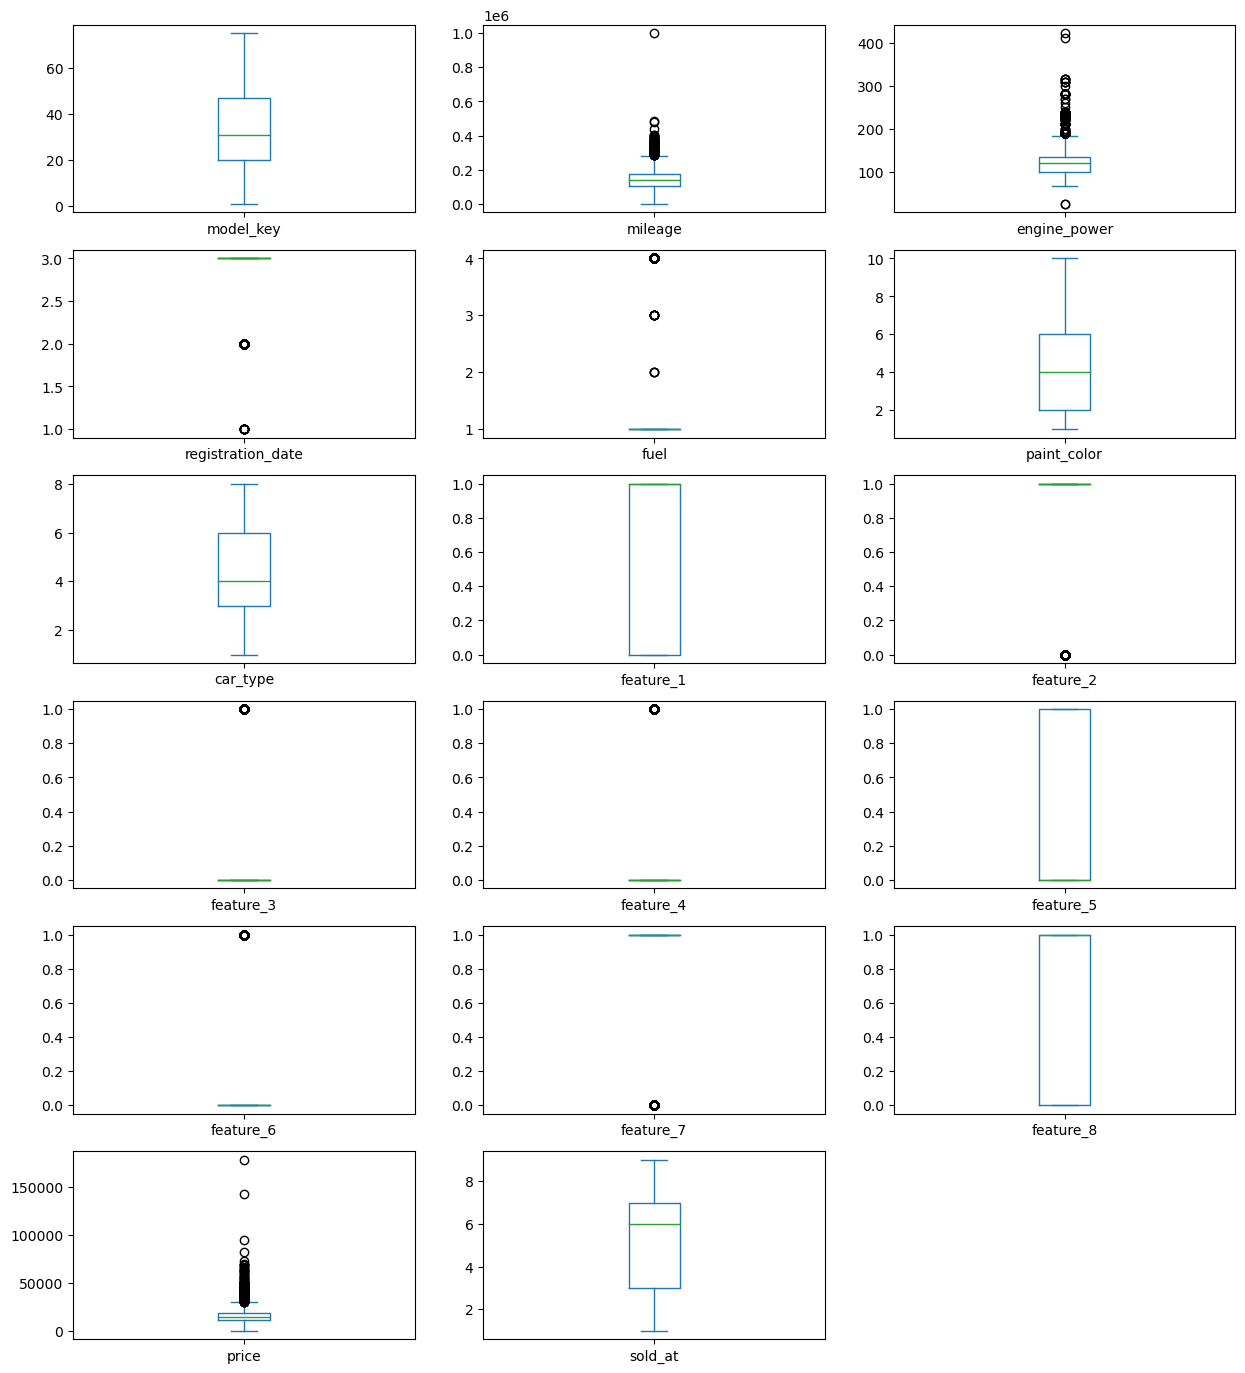

In [156]:
df.plot(kind="box",subplots=True,layout=(7,3),figsize=(15,20))

## mileage, engine power

<AxesSubplot:>

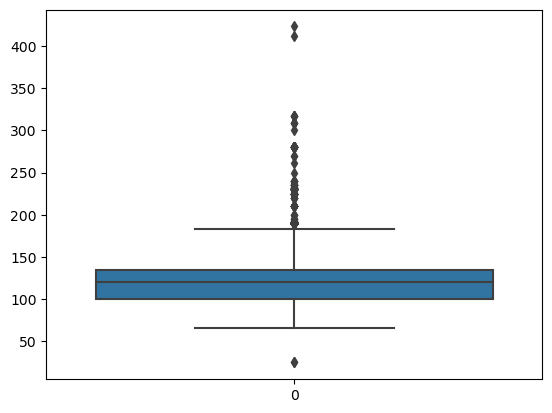

In [165]:
sns.boxplot(df['engine_power'])

In [170]:
df['engine_power'].quantile(0.87)

180.0

In [164]:
# for median imputation

def impute(column,quant1, quant2): #quant1 for lower fence; quant2 for upper fence
    if quant1 is 0.0:
        # considering upper fence
        quantile_value_ufence = column.quantile(quant2)
        for val in column:
            if val < quantile_value_ufence:
                column.replace(val,np.median(column), inplace=True)
    
    if quant2 is 0.0:
        # considering lower fence
        quantile_value_lfence = column.quantile(quant1)
        for val in column:
            if val > quantile_value_lfence:
                column.replace(val,np.median(column), inplace=True)
                
    else:
        quantile_value_ufence = column.quantile(quant2)
        quantile_value_lfence = column.quantile(quant1)
        for val in column:
            if val > quantile_value_ufence or val < quantile_value_lfence:
                column.replace(val,np.median(column), inplace=True)

In [188]:
impute(df['mileage'], 0.0, 0.98)
impute(df['engine_power'], 0.0, 0.87)

# FEATURE SELECTION

In [189]:
X = df.drop(columns = ['price'])
y = df['price']

In [190]:
X.columns

Index(['model_key', 'mileage', 'engine_power', 'registration_date', 'fuel',
       'paint_color', 'car_type', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'sold_at'],
      dtype='object')

In [192]:
y

0       11300
1       69700
2       10200
3       25100
4       33400
        ...  
4838    14600
4839    17500
4840    17000
4841    22700
4842    15500
Name: price, Length: 4841, dtype: int64

In [198]:
df.shape

(4841, 17)

## 1. Information Gain

In [194]:
importance = mutual_info_regression(X,y)
sample_df = pd.Series(importance, index = X.columns)

In [195]:
sample_df.nlargest(10) #top 10 most important feature in our dataset

engine_power         0.228954
model_key            0.214642
feature_8            0.176048
registration_date    0.174280
mileage              0.111453
feature_4            0.111247
feature_5            0.094953
car_type             0.083919
feature_2            0.072082
feature_1            0.058350
dtype: float64

## Extra Trees Regressor

In [173]:
ext = ExtraTreesRegressor()

In [196]:
ext.fit(X,y)
ext.feature_importances_

array([0.20687093, 0.1693147 , 0.06220714, 0.07352862, 0.01068425,
       0.0397221 , 0.03042587, 0.02201779, 0.02624576, 0.01683081,
       0.06624758, 0.03503509, 0.01977683, 0.01130138, 0.17965738,
       0.03013377])

<AxesSubplot:>

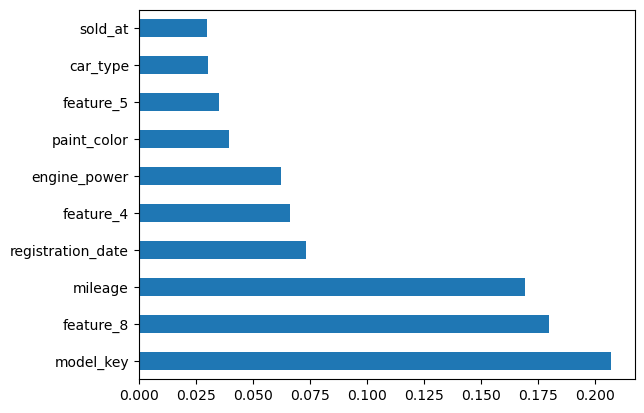

In [197]:
rank = pd.Series(ext.feature_importances_, index=X.columns)
rank.nlargest(10).plot(kind='barh')

## most 10 important feature according to ExtraTrees Regressor. Almost matches with information gain. 


## From information gain and ExtraTrees, we see feature_8 is the most important feature to predict the price of the car.

# From correlation matrix in profile report, no 2 columns have very high multi-collinearity

In [201]:
# checking multi-collinearity manually for confirmation
VIF = pd.DataFrame()

Xcopy = X.copy()
ycopy = y.copy()
Xtrain, Xtest, ytrain, ytest = train_test_split(Xcopy,ycopy,test_size=0.3,random_state=42)

std = StandardScaler()

Xtrain = std.fit_transform(Xtrain,ytrain)
Xtest = std.transform(Xtest)

In [202]:
VIF['vif'] = [variance_inflation_factor(Xtrain,i) for i in range(Xtrain.shape[1])]

In [203]:
VIF['columns'] = Xcopy.columns

In [204]:
VIF

,vif,columns
0,2.587224,model_key
1,1.176882,mileage
2,1.649137,engine_power
3,1.276278,registration_date
4,1.082889,fuel
5,1.019087,paint_color
6,1.851311,car_type
7,1.372099,feature_1
8,1.421768,feature_2
9,1.140562,feature_3


#### VIF score is not high for any columns, therefore, no need to drop any columns and everything can be used in model building

# Model Building

In [206]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,train_size=0.75, random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(3630, 16) (1211, 16) (3630,) (1211,)


In [216]:
std = StandardScaler()

Xtrain = std.fit_transform(Xtrain,ytrain)
Xtest = std.transform(Xtest)

# Checking which base model gives better results

# Models used - 
1. Random Forest
2. Histogram GB
3. Light GB

In [ ]:
new_df = pd.DataFrame()
# pd.DataFrame(data, columns=['Name', 'Age'])

### 1. Random Forest

In [233]:
# BASE MODEL
rf = RandomForestRegressor()
rf.fit(Xtrain,ytrain)

RandomForestRegressor()

In [235]:
scores = cross_val_score(rf, Xtrain,ytrain, scoring='r2', cv = KFold(5))
print("Training accuracy = ",scores.mean())

Training accuracy =  0.7472698901051376


In [236]:
scores = cross_val_score(rf, Xtest,ytest, scoring='r2', cv = KFold(5))
print("Testing accuracy = ",scores.mean())

Testing accuracy =  0.785949714390546


### 2. HistGB 

In [254]:
hist  = HistGradientBoostingRegressor()
hist.fit(Xtrain,ytrain)

HistGradientBoostingRegressor()

In [255]:
scores = cross_val_score(hist, Xtrain,ytrain, scoring='r2', cv = KFold(5))
print("Training accuracy = ",scores.mean())

Training accuracy =  0.7693979304350522


In [256]:
scores = cross_val_score(hist, Xtest,ytest, scoring='r2', cv = KFold(5))
print("Testing accuracy = ",scores.mean())

Testing accuracy =  0.7501533976546723


### 3. LightGBM

In [257]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(Xtrain,ytrain)

LGBMRegressor()

In [258]:
scores = cross_val_score(lgbm, Xtrain,ytrain, scoring='r2', cv = KFold(5))
print("Training accuracy = ",scores.mean())

Training accuracy =  0.7657062591848574


In [259]:
scores = cross_val_score(lgbm, Xtest,ytest, scoring='r2', cv = KFold(5))
print("Testing accuracy = ",scores.mean())

Testing accuracy =  0.7409542141124559


# Random Forest gives the BEST prediction but LightGBM gives better predictions at much faster rate saving a lot of time. 

# feature_8 is the most important feature amongst all the "unnamed" features. 

In [266]:
pickle.dump(lgbm,open('regmodel.pkl','wb')) # pickling model for further use